# 3.2线性回归的从零开始实现

In [1]:
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

## 3.2.1生成数据集

In [2]:
num_inputs = 2 # 输入个数（特征数）为2
num_examples = 1000 # 训练数据集样本数为1000
true_w = [2,-3.4] # 模型的真实权重
true_b = 4.2 # 模型的真实偏差
features = torch.randn(num_examples,num_inputs,dtype=torch.float32) # 生成特征：1000*2
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b # 生成标签：y=w[0]x[1]+w[1]x[2]+b
labels += torch.tensor(np.random.normal(0,0.01,size = labels.size()),dtype = torch.float32) # 加噪声项：1000
# 注意！这里的features和lables要注明torch.float32

In [3]:
print(features[0],labels[0])

tensor([0.3032, 0.5773]) tensor(2.8549)


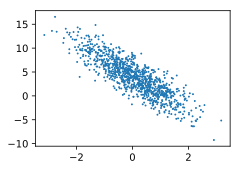

In [4]:
def use_svg_display():
    display.set_matplotlib_formats('svg') #  用矢量图显示
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize # 设置图的尺⼨
    
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(),1) # 1：设置点的形状的大小

## 3.2.2读取数据

In [5]:
def data_iter(batch_size, features, labels):
    '''
    每次返回 batch_size （批量大小）个随机样本的特征和标签
    
    '''
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size,num_examples)]) # 最后一次可能不⾜一个batch
        yield features.index_select(0, j), labels.index_select(0,j) # yield相当return+迭代器
        # features.index_select(0, j)：0表示维度，j表示一系列索引号

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break

tensor([[ 0.7322, -0.7187],
        [-0.5290, -0.9722],
        [-0.3178,  1.0081],
        [-0.8319, -0.2266],
        [ 1.3182,  1.8590],
        [ 0.7201, -1.1370],
        [-0.1149, -1.6678],
        [ 1.3527, -0.7801],
        [-1.6215, -0.0364],
        [ 0.3775, -1.5266]]) tensor([ 8.0969,  6.4359,  0.1444,  3.3019,  0.5083,  9.5106,  9.6397,  9.5679,
         1.0925, 10.1603])


## 3.2.3初始化模型参数

In [7]:
# 权重初始化成均值为0、标准差为0.01的正态随机数，偏差初始化成0
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)),dtype=torch.float32) # 维度：2*1
b = torch.zeros(1, dtype=torch.float32) # 维度：1*1

In [8]:
# 模型训练需要对这些参数求梯度来迭代参数的值
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 3.2.4定义模型

In [9]:
def linreg(X, w, b): 
    return torch.mm(X, w) + b
    # torch.mm：矩阵乘法
    # torch.mul：矩阵对应位相乘，维度必须相等！

## 3.2.5定义损失函数

In [10]:
def squared_loss(y_hat, y): 
    return (y_hat - y.view(y_hat.size())) ** 2 / 2 # 返回向量
    # y_hat的形状是[n, 1]，而y的形状是[n]，两者相减得到的结果的形状是[n, n]，
    # 相当于用y_hat的每一个元素分别减去y的所有元素，所以无法得到正确的损失值
    # y_hat.view(-1)的形状是[n]，与y一致，可以相减
    # y.view(-1)的形状仍是[n]
    # y.view(y_hat.shape)和y.view(-1, 1)的形状都是[n, 1]，与y_hat一致，可以相减

## 3.2.6定义优化算法

In [11]:
def sgd(params, lr, batch_size): 
    '''
    得到一个批量样本的梯度和，除以批量大小来得到平均值
    '''
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时⽤的param.data
        # tensor.data：修改tensor的值，但未被autograd记录，不会影响反向传播

## 3.2.7训练模型

In [12]:
lr = 0.03
num_epochs = 5
net = linreg
loss = squared_loss

for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使⽤训练数据集中所有样本一次（假设样本数能够被批量⼤小整除）
    # X和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum() # l是有关⼩批量X和y的损失
        # l是张量，将所有张量的元素加权求和转换为标量
        # 假设y是由自变量x而来，w是和y同行的张量，则y.backward(w)：先计算l=torch.sum(y*w)，l是标量，求l对x的导数
        l.backward() # ⼩批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size) # 使⽤用⼩批量随机梯度下降迭代模型参数
        
        # 梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.052497
epoch 2, loss 0.000227
epoch 3, loss 0.000050
epoch 4, loss 0.000049
epoch 5, loss 0.000049


In [13]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 2.0004],
        [-3.3994]], requires_grad=True)
4.2 
 tensor([4.1997], requires_grad=True)
